In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.random import randn
np.random.seed(0)
import pickle
import gzip
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle
from tqdm import tqdm

In [80]:
# data loading

data_ver = '3'

# NOISE
with gzip.open(f'../data/segment_with_noise_v{data_ver}/ll_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    ll_seg_noise = pickle.load(f)
with gzip.open(f'../data/segment_with_noise_v{data_ver}/rl_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    rl_seg_noise = pickle.load(f)

# GROUND TRUTH
with gzip.open(f'../data/segment_groud_truth_v2/rl_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open(f'../data/segment_groud_truth_v2/ll_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_noise))
print(ll_seg_noise[0].shape[0])
ll_seg_noise[0].head()

500
153


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,y_noise,x_noise
68268,274.111469,109.920335,0.00,5.87,152.640,0.634,1.101,0.008203,0.006283,0.237,-0.150,274.552482,109.713725
68293,272.808525,110.598795,-0.01,5.88,152.633,0.648,1.087,-0.014137,0.017453,0.212,-0.143,272.908564,110.574182
68318,271.504469,111.278905,0.00,5.90,152.626,0.677,1.130,-0.000175,-0.007854,0.320,-0.018,271.749154,111.113036
68343,270.195971,111.961492,-0.01,5.91,152.607,0.720,1.148,-0.020071,-0.006981,0.242,-0.473,270.756194,112.243151
68368,268.884140,112.646555,-0.01,5.93,152.600,0.716,1.147,0.009076,-0.000349,0.054,-0.277,269.351030,112.376572


In [147]:
rl_seg_gps_gt[0].shape, rl_seg_noise[0].shape

((3822, 11), (153, 13))

In [51]:
# example segment
exp_rl_seg_noise = ll_seg_noise[91].reset_index()
print(exp_rl_seg_noise.shape)
exp_rl_seg_noise.head()

(153, 15)


,index,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,lane,y_noise,x_noise
0,21752,42.246163,-83.551625,0.00,5.07,356.630,2.888,-1.093,0.010123,-0.010472,0.595,0.101,1,42.246163,-83.551626
1,21777,42.246175,-83.551626,0.00,5.09,356.549,2.862,-1.050,0.002443,0.013788,0.547,0.120,1,42.246176,-83.551628
2,21802,42.246186,-83.551627,0.00,5.10,356.386,2.890,-1.048,-0.003491,0.011868,0.601,0.112,1,42.246186,-83.551628
3,21827,42.246198,-83.551628,-0.01,5.11,356.233,2.897,-1.079,0.008552,0.002967,0.536,0.096,1,42.246199,-83.551632
4,21852,42.246209,-83.551629,0.00,5.13,356.075,2.917,-1.061,0.003840,0.015010,0.634,0.172,1,42.246208,-83.551629


In [65]:
# normalize time for calculating dt

# sample_freq = 50 # 5hz
sample_freq = 25 # 10hz

t_norm = MinMaxScaler().fit_transform(np.linspace(0, exp_rl_seg_noise.shape[0] * sample_freq * 0.01, num=exp_rl_seg_noise.shape[0]).reshape(-1,1)).flatten()
dt = 0.01 * sample_freq
dt_norm = t_norm[1] - t_norm[0]
dt, dt_norm

(0.25, 0.006578947368421052)

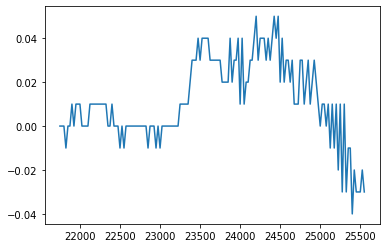

In [22]:
plt.plot(exp_rl_seg_noise.Vy)

In [151]:
exp_v_est = []
time_delta = 25 * 0.01

for index, row in exp_rl_seg_noise.iterrows():
    try:
        # actual
        start = (row['y'], row['x'])
        end = (exp_rl_seg_noise.iloc[index+1]['y'], exp_rl_seg_noise.iloc[index+1]['x'])
        exp_v_est.append(great_circle(start, end).meters / time_delta)
    except:
        pass

In [154]:
mean_squared_error(exp_rl_seg_noise['Vx'][:-1], exp_v_est)

0.000183304816920446

Text(0, 0.5, 'Vx')

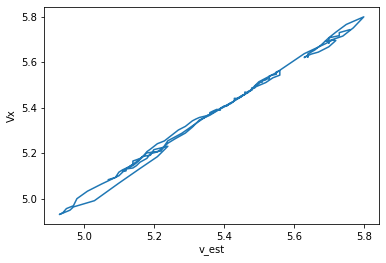

In [153]:
plt.plot(exp_rl_seg_noise['Vx'][:-1], exp_v_est)
plt.xlabel('v_est')
plt.ylabel('Vx')

## linear kalman filter design

### scratch work

In [16]:
x_noise = exp_rl_seg_noise['x_norm_noise'].values
y_noise = exp_rl_seg_noise['y_norm_noise'].values
Vx = exp_rl_seg_noise['Vx_norm'].values
Vy = exp_rl_seg_noise['Vy_norm'].values
alpha_Xv = exp_rl_seg_noise['alpha_Xv_norm'].values
alpha_Yv = exp_rl_seg_noise['alpha_Yv_norm'].values

gps_sig = 0.005
# dt = (exp_ll_seg_gps_noise.index[2] - exp_ll_seg_gps_noise.index[1]) * 0.01
d3xdt3 = np.gradient(exp_rl_seg_noise['alpha_Xv_norm'], dt)
d3ydt3 = np.gradient(exp_rl_seg_noise['alpha_Yv_norm'], dt)

A = np.array([ 
    [1, dt, (dt**2)/2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, (dt**2)/2],
    [0, 0, 0, 0, 1, dt],
    [0, 0, 0, 0, 0, 1],
    ])

Q1 = np.array([(dt**3)/6, (dt**2)/2, dt, 0, 0, 0])
Q1 = np.expand_dims(Q1, 1)
Q2 = np.array([0, 0, 0, (dt**3)/6, (dt**2)/2, dt])
Q2 = np.expand_dims(Q2, 1)

j_var = max(np.var(d3xdt3), np.var(d3ydt3))
Q = j_var * (Q1 @ Q1.T + Q2 @ Q2.T)

H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    ])

R = np.diag(np.array([gps_sig**2, gps_sig**2]))

x_init = np.array([x_noise[0], Vx[0], alpha_Xv[0], y_noise[0], Vy[0], alpha_Yv[0]])
P_init = 0.001 * np.eye(len(x_init))  # small initial prediction error

In [17]:
# create an observation vector of noisy GPS signals
observations = np.array([x_noise, y_noise]).T

# matrix dimensions, nxm
nx = Q.shape[0]
ny = R.shape[0]     
nt = observations.shape[0]

# allocate identity matrix for re-use
Inx = np.eye(nx)

# allocate result matrices
x_pred = np.zeros((nt, nx))      # prediction of state vector
P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
x_est = np.zeros((nt, nx))       # estimation of state vector
P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
K = np.zeros((nt, nx, ny))       # Kalman Gain

# set initial prediction
x_pred[0] = x_init
P_pred[0] = P_init

for i in range(nt):

    # prediction stage
    if i > 0:
        x_pred[i] = A @ x_est[i-1]
        P_pred[i] = A @ P_est[i-1] @ A.T + Q

    # estimation stage
    y_obs = observations[i]
    K[i] = P_pred[i] @ H.T @ np.linalg.inv((H @ P_pred[i] @ H.T) + R)
    x_est[i] = x_pred[i] + K[i] @ (y_obs - H @ x_pred[i])
    P_est[i] = (Inx - K[i] @ H) @ P_pred[i]

### kf()

In [123]:
def kf(segment_df):

    # states
    x_noise = segment_df['x_noise'].values
    y_noise = segment_df['y_noise'].values
    Vx = segment_df['Vx'].values
    Vy = segment_df['Vy'].values
    alpha_Xv = segment_df['alpha_Xv'].values
    alpha_Yv = segment_df['alpha_Yv'].values
    d3xdt3 = np.gradient(segment_df['alpha_Xv'], dt)
    d3ydt3 = np.gradient(segment_df['alpha_Yv'], dt)

    gps_sig = 0.25

    # initialization
    A = np.array([
        [1, dt, (dt**2)/2, 0, 0, 0],
        [0, 1, dt, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, dt, (dt**2)/2],
        [0, 0, 0, 0, 1, dt],
        [0, 0, 0, 0, 0, 1],
        ])

    H = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        ])

    Q1 = np.array([(dt**3)/6, (dt**2)/2, dt, 0, 0, 0])
    Q1 = np.expand_dims(Q1, 1)
    Q2 = np.array([0, 0, 0, (dt**3)/6, (dt**2)/2, dt])
    Q2 = np.expand_dims(Q2, 1)

    j_var = max(np.var(d3xdt3), np.var(d3ydt3))
    Q = j_var * (Q1 @ Q1.T + Q2 @ Q2.T)
    R = np.diag(np.array([gps_sig**2, gps_sig**2]))

    x_init = np.array([x_noise[0], Vx[0], alpha_Xv[0], y_noise[0], Vy[0], alpha_Yv[0]])
    P_init = 1 * np.eye(len(x_init))  # small initial prediction error

    # state vector
    observations = np.array([x_noise, y_noise]).T

    # matrix dimensions, nxm
    nx = Q.shape[0]
    ny = R.shape[0]     
    nt = observations.shape[0]

    # allocate identity matrix for re-use
    Inx = np.eye(nx)

    # allocate result matrices
    x_pred = np.zeros((nt, nx))      # prediction of state vector
    P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
    x_est = np.zeros((nt, nx))       # estimation of state vector
    P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
    K = np.zeros((nt, nx, ny))       # Kalman Gain

    # set initial prediction
    x_pred[0] = x_init
    P_pred[0] = P_init

    for i in range(nt):

        # prediction stage
        if i > 0:
            x_pred[i] = A @ x_est[i-1]
            P_pred[i] = A @ P_est[i-1] @ A.T + Q

        # estimation stage
        y_obs = observations[i]
        K[i] = P_pred[i] @ H.T @ np.linalg.inv((H @ P_pred[i] @ H.T) + R)
        x_est[i] = x_pred[i] + K[i] @ (y_obs - H @ x_pred[i])
        P_est[i] = (Inx - K[i] @ H) @ P_pred[i]
    
    return x_est, x_noise, y_noise, segment_df['x'].values, segment_df['y'].values

### example estimation

In [7]:
x_noise = exp_rl_seg_noise['x_norm_noise'].values
y_noise = exp_rl_seg_noise['y_norm_noise'].values

x_est_sample, x_noise, y_noise, x, y  = kf(exp_rl_seg_noise)

NameError: name 'exp_rl_seg_noise' is not defined

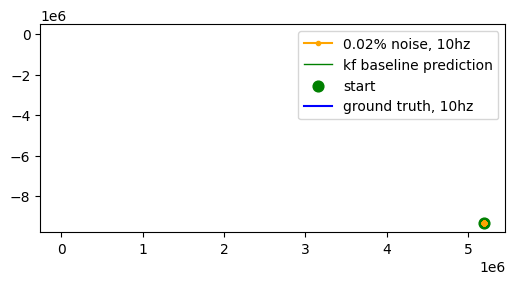

In [235]:
plt.figure(dpi=100, figsize=(6, 2.75))

plt.plot(y_noise, x_noise, '-o', label='0.02% noise, 10hz', ms=3, c='orange')
plt.plot(x_est_sample[:, 3], x_est_sample[:, 0], '-', linewidth=1, label='kf baseline prediction', c='green')
plt.scatter(x_est_sample[:, 3][0], x_est_sample[:, 0][0], label='start', s=60, c='green')
plt.plot(exp_rl_seg_noise['y_norm'].values, exp_rl_seg_noise['x_norm'].values, label='ground truth, 10hz', c='blue')

plt.legend()

### batch estimation

In [124]:
# runtime ~= 5s
# list of dataframe
rl_seg_pred = []

for df in rl_seg_noise:
    x_est_sample, x_noise, y_noise, x, y = kf(df)
    x_est_df = pd.DataFrame(
        {'x_est': x_est_sample[:, 0],
        'y_est': x_est_sample[:, 3],
        'Vx_est': x_est_sample[:, 1],
        'Vy_est': x_est_sample[:, 4],
        'x_noise': x_noise,
        'y_noise': y_noise,
        'x': x,
        'y': y
        }
    )
    rl_seg_pred.append(x_est_df)    

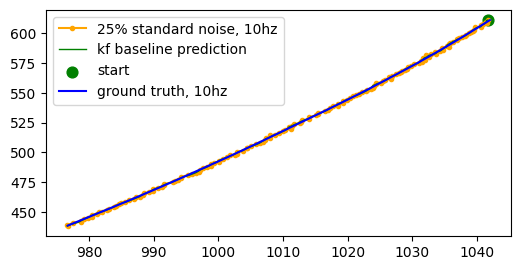

In [125]:
sample = 1
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_pred[sample]['y_noise'], rl_seg_pred[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(rl_seg_pred[sample]['y_est'], rl_seg_pred[sample]['x_est'], '-', linewidth=1, label='kf baseline prediction', c='green')
plt.scatter(rl_seg_pred[sample]['y_est'][0], rl_seg_pred[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(rl_seg_pred[sample]['y'], rl_seg_pred[sample]['x'], label='ground truth, 10hz', c='blue')

plt.legend()

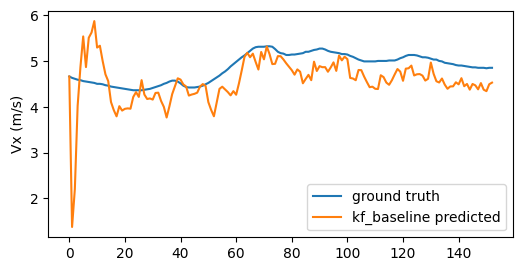

In [126]:
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_noise[sample]['Vx'].values, label='ground truth')
plt.plot(abs(rl_seg_pred[sample].reset_index()['Vx_est']), label='kf_baseline predicted')
plt.ylabel('Vx (m/s)')
plt.legend()

In [114]:
def inv_normalize_df(df_lst):
    # inverse normalize the GPS coordinates in rl_seg_pred

    # constants
    x_max = -83.55144472
    y_max = 42.24829894
    x_min = -83.56611364
    y_min = 42.23836889

    for df in df_lst:

        df['y_est'] = df['y_est'] * (y_max - y_min) + y_min
        df['x_est'] = df['x_est'] * (x_max - x_min) + x_min

        df['y'] = df['y'] * (y_max - y_min) + y_min
        df['x'] = df['x'] * (x_max - x_min) + x_min
    
        df['y_noise'] = df['y_noise'] * (y_max - y_min) + y_min
        df['x_noise'] = df['x_noise'] * (x_max - x_min) + x_min
        
    return df_lst  

In [128]:
# calculate prediction error in meters

x_max = -83.55144472
y_max = 42.24829894
x_min = -83.56611364
y_min = 42.23836889

y_pred_scale = []
y_gt_scale = []
y_noise_scale = []

rl_seg_pred_scaled = rl_seg_pred
# inv_normalize_df(rl_seg_pred)

# estimation
for df in rl_seg_pred_scaled:

    y_pred_scale.append(
        np.append(df['y_est'].values.reshape(153, 1), df['x_est'].values.reshape(153, 1), axis=1
    ))
    y_gt_scale.append(
        np.append(df['y'].values.reshape(153, 1), df['x'].values.reshape(153, 1), axis=1
    ))
    y_noise_scale.append(
        np.append(df['y_noise'].values.reshape(153, 1), df['x_noise'].values.reshape(153, 1), axis=1
    ))

y_pred_scale = np.asarray(y_pred_scale)
y_gt_scale = np.asarray(y_gt_scale)
y_noise_scale = np.asarray(y_noise_scale)

great_circie_err = []
great_circie_noise_err = []

for i in np.arange(len(rl_seg_pred)):
    for traj_i in np.arange(153):
        pred_coord = (y_pred_scale[i][traj_i][0], y_pred_scale[i][traj_i][1])
        actual_coord = (y_gt_scale[i][traj_i][0], y_gt_scale[i][traj_i][1])
        noise_coord = (y_noise_scale[i][traj_i][0], y_noise_scale[i][traj_i][1])

        great_circie_err.append(math.dist(pred_coord, actual_coord)) # meter
        great_circie_noise_err.append(math.dist(noise_coord, actual_coord)) # meter
        

        # great_circie_err.append(great_circle(pred_coord, actual_coord).miles * 1609.34) # meter
        # great_circie_noise_err.append(great_circle(noise_coord, actual_coord).miles * 1609.34) # meter

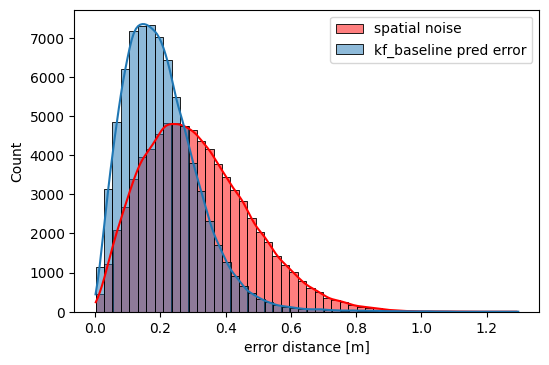

In [129]:
plt.figure(dpi=100)
ax = sns.histplot(
    great_circie_noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    great_circie_err, 
    bins=50, label='kf_baseline pred error', kde=True)

plt.xlabel('error distance [m]')
plt.legend()
plt.show()

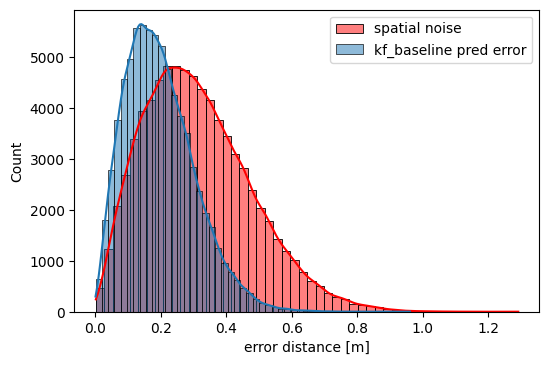

In [176]:
plt.figure(dpi=100)
ax = sns.histplot(
    great_circie_noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    great_circie_err, 
    bins=50, label='kf_baseline pred error', kde=True)

plt.xlabel('error distance [m]')
plt.legend()
plt.show()

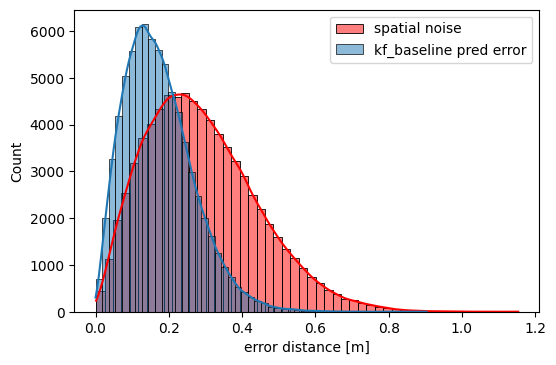

In [122]:
plt.figure(dpi=100)
ax = sns.histplot(
    great_circie_noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    great_circie_err, 
    bins=50, label='kf_baseline pred error', kde=True)

plt.xlabel('error distance [m]')
plt.legend()
plt.show()

In [46]:
# prediction error of single trajectory

x_max = -83.55144472
y_max = 42.24829894
x_min = -83.56611364
y_min = 42.23836889

y_exp_test_scale = []
y_exp_noise_scale = []
y_exp_pred_scale = []

# estimation
y_scale = x_est_sample[:, 3] * (y_max - y_min) + y_min
x_scale = x_est_sample[:, 0] * (x_max - x_min) + x_min

coord_scale = np.append(
    y_scale.reshape(153, 1), x_scale.reshape(153, 1), axis=1
)
y_exp_pred_scale.append(coord_scale)

# gt
y_scale = exp_rl_seg_noise['y_norm'].values * (y_max - y_min) + y_min
x_scale = exp_rl_seg_noise['x_norm'].values * (x_max - x_min) + x_min
coord_scale = np.append(
    y_scale.reshape(153, 1), x_scale.reshape(153, 1), axis=1
)
y_exp_test_scale.append(coord_scale)

# noise
y_scale = y_noise * (y_max - y_min) + y_min
x_scale = x_noise * (x_max - x_min) + x_min
coord_scale = np.append(
    y_scale.reshape(153, 1), x_scale.reshape(153, 1), axis=1
)
y_exp_noise_scale.append(coord_scale)

y_test_scale = np.asarray(y_exp_test_scale)
y_pred_scale = np.asarray(y_exp_pred_scale)
y_exp_noise_scale = np.asarray(y_exp_noise_scale)

great_circie_err = []
great_circie_noise_err = []

for traj_i in np.arange(153):
    pred_coord = (y_pred_scale[0][traj_i][0], y_pred_scale[0][traj_i][1])
    actual_coord = (y_test_scale[0][traj_i][0], y_test_scale[0][traj_i][1])
    noise_coord = (y_exp_noise_scale[0][traj_i][0], y_exp_noise_scale[0][traj_i][1])

    great_circie_err.append(great_circle(pred_coord, actual_coord).miles * 1609.34) # meter
    great_circie_noise_err.append(great_circle(noise_coord, actual_coord).miles * 1609.34) # meter

In [177]:
def traj_distances(df):
    # calculate 

    length_m = 0
    length_m_pred = 0
    length_m_noise = 0

    for index, row in df.iterrows():
        try:
            # actual
            start = (row['y'], row['x'])
            end = (df.iloc[index+1]['y'], df.iloc[index+1]['x'])
            length_m += great_circle(start, end).meters

            # predicted
            start = (row['y_est'], row['x_est'])
            end = (df.iloc[index+1]['y_est'], df.iloc[index+1]['x_est'])
            length_m_pred += great_circle(start, end).meters

            # noise
            start = (row['y_noise'], row['x_noise'])
            end = (df.iloc[index+1]['y_noise'], df.iloc[index+1]['x_noise'])
            length_m_noise += great_circle(start, end).meters

        except:
            pass
    
    return length_m, length_m_pred, length_m_noise

In [102]:
def traj_distances_proj(df):

    length_m = 0
    length_m_pred = 0
    length_m_noise = 0

    for index, row in df.iterrows():
        try:
            # actual
            start = (row['y'], row['x'])
            end = (df.iloc[index+1]['y'], df.iloc[index+1]['x'])
            length_m += math.dist(start, end)

            # predicted
            start = (row['y_est'], row['x_est'])
            end = (df.iloc[index+1]['y_est'], df.iloc[index+1]['x_est'])
            length_m_pred += math.dist(start, end)

            # noise
            start = (row['y_noise'], row['x_noise'])
            end = (df.iloc[index+1]['y_noise'], df.iloc[index+1]['x_noise'])
            length_m_noise += math.dist(start, end)

        except:
            pass
    
    return length_m, length_m_pred, length_m_noise

In [130]:
length_m_500 = []
length_m_pred_500 = []
length_m_noise_500 = []

for df in tqdm(rl_seg_pred_scaled):
    length_m, length_m_pred, length_m_noise = traj_distances_proj(df)
    length_m_500.append(length_m)
    length_m_pred_500.append(length_m_pred)
    length_m_noise_500.append(length_m_noise)

100%|██████████| 500/500 [00:33<00:00, 14.75it/s]


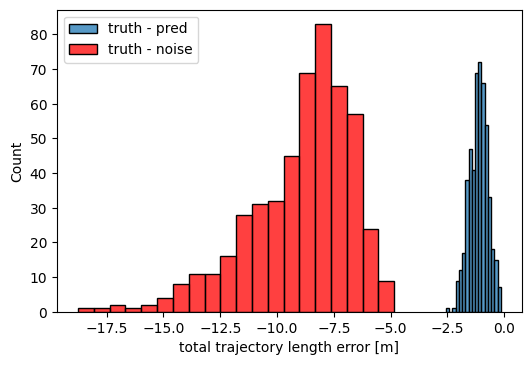

In [131]:
plt.figure(dpi=100)
sns.histplot(np.array(length_m_500) - np.array(length_m_pred_500), label='truth - pred')
sns.histplot(np.array(length_m_500) - np.array(length_m_noise_500), label='truth - noise', color='red')
plt.xlabel('total trajectory length error [m]')
plt.legend()

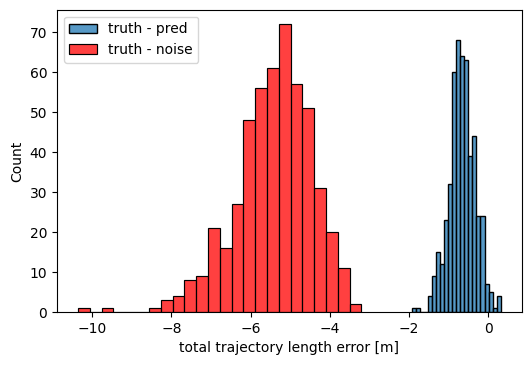

In [223]:
plt.figure(dpi=100)
sns.histplot(np.array(length_m_500) - np.array(length_m_pred_500), label='truth - pred')
sns.histplot(np.array(length_m_500) - np.array(length_m_noise_500), label='truth - noise', color='red')
plt.xlabel('total trajectory length error [m]')
plt.legend()

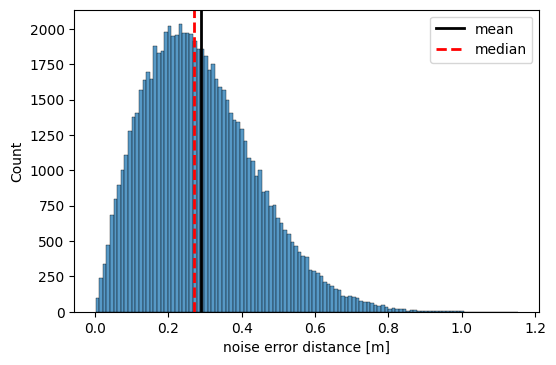

In [53]:
ax = sns.histplot(great_circie_noise_err)
ax.axvline(np.average(great_circie_noise_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_noise_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('noise error distance [m]')
plt.legend()

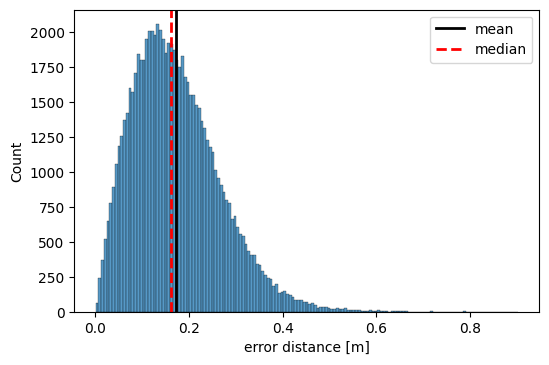

In [54]:
ax = sns.histplot(great_circie_err)
ax.axvline(np.average(great_circie_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('error distance [m]')
plt.legend()

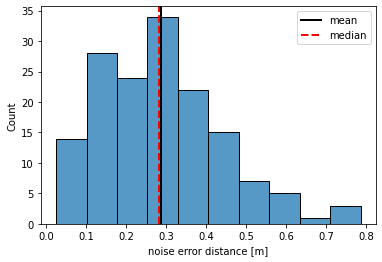

In [47]:
ax = sns.histplot(great_circie_noise_err)
ax.axvline(np.average(great_circie_noise_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_noise_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('noise error distance [m]')
plt.legend()

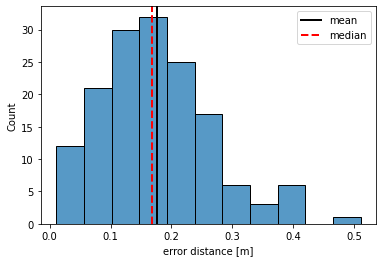

In [48]:
ax = sns.histplot(great_circie_err)
ax.axvline(np.average(great_circie_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('error distance [m]')
plt.legend()

In [10]:
noise = np.random.normal(0, 1, size=(1000, 2)) * 0.0001
noise[:,0] = noise[:,0] * (x_max - x_min) + x_min
noise[:,1] = noise[:,1] * (y_max - y_min) + y_min
noise = list(zip(noise[:,0], noise[:,1]))

zeros = np.zeros((1000, 2))
zeros[:,0] = zeros[:,0] * (x_max - x_min) + x_min
zeros[:,1] = zeros[:,1] * (y_max - y_min) + y_min
zeros = list(zip(zeros[:,0], zeros[:,1]))

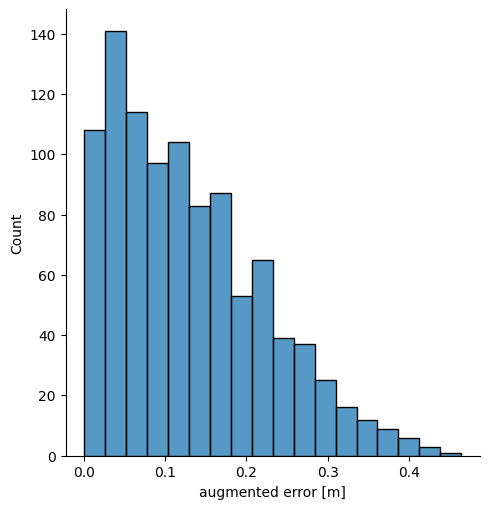

In [11]:
# augmented noise distribution in meters

distances = [great_circle(noise[i], zeros[i]).miles * 1609.34 for i in np.arange(1000)]
sns.displot(distances)
plt.xlabel('augmented error [m]')
plt.show()

## EKF design

### ekf()

In [75]:
def eval_h(x_pred):

    # expand prediction of state vector
    px, vx, ax, py, vy, ay = x_pred

    # compute angular vel
    w = (vx*ay - vy*ax) / (vx**2 + vy**2)

    # compute speed
    s = np.sqrt(vx**2 + vy**2)

    return np.array([px, py, w, s])

def eval_H(x_pred):

    # expand prediction of state vector
    px, vx, ax, py, vy, ay = x_pred
    V2 = vx**2 + vy**2

    # angular vel partial derivs
    dwdvx = (V2*ay - 2*vx*(vx*ay-vy*ax)) / (V2**2)
    dwdax = -vy / V2
    dwdvy = (-V2*ax - 2*vy*(vx*ay-vy*ax)) / (V2**2)
    dwday = vx / V2

    # speed partial derivs
    dsdvx = vx / np.sqrt(V2)
    dsdvy = vy / np.sqrt(V2)

    return np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, dwdvx, dwdax, 0, dwdvy, dwday],
        [0, dsdvx, 0, 0, dsdvy, 0],
        ])

In [132]:
def ekf(segment_df, gps_sig, omega_sig, v_sig):

    # states

    # position with noise
    x_noise = segment_df['x_noise'].values
    y_noise = segment_df['y_noise'].values

    # speed
    Vx = segment_df['Vx'].values
    Vy = segment_df['Vy'].values

    # accel
    alpha_Xv = segment_df['alpha_Xv'].values
    alpha_Yv = segment_df['alpha_Yv'].values

    # jerk
    d3xdt3 = np.gradient(segment_df['alpha_Xv'], dt)
    d3ydt3 = np.gradient(segment_df['alpha_Yv'], dt)

    # angular rate
    omega_Xv = segment_df['omega_Xv'].values # * np.pi/180 # [deg/s] to [rad/s]

    # initialization
    A = np.array([
        [1, dt, (dt**2)/2, 0, 0, 0],
        [0, 1, dt, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, dt, (dt**2)/2],
        [0, 0, 0, 0, 1, dt],
        [0, 0, 0, 0, 0, 1],
        ])

    H = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        ])

    Q1 = np.array([(dt**3)/6, (dt**2)/2, dt, 0, 0, 0])
    Q1 = np.expand_dims(Q1, 1)
    Q2 = np.array([0, 0, 0, (dt**3)/6, (dt**2)/2, dt])
    Q2 = np.expand_dims(Q2, 1)

    j_var = max(np.var(d3xdt3), np.var(d3ydt3))
    Q = j_var * (Q1 @ Q1.T + Q2 @ Q2.T)

    # R = np.diag(np.array([gps_sig**2, gps_sig**2]))
    R = np.diag(np.array([gps_sig**2, gps_sig**2, omega_sig**2, v_sig**2]))

    x_init = np.array([x_noise[0], Vx[0], alpha_Xv[0], y_noise[0], Vy[0], alpha_Yv[0]])
    P_init = 1 * np.eye(len(x_init))  # small initial prediction error

    # state vector
    observations = np.array([x_noise, y_noise, omega_Xv, Vx]).T

    # matrix dimensions, nxm
    nx = Q.shape[0]
    ny = R.shape[0]     
    nt = observations.shape[0]

    # allocate identity matrix for re-use
    Inx = np.eye(nx)

    # allocate result matrices
    x_pred = np.zeros((nt, nx))      # prediction of state vector
    P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
    x_est = np.zeros((nt, nx))       # estimation of state vector
    P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
    K = np.zeros((nt, nx, ny))       # Kalman Gain

    # set initial prediction
    x_pred[0] = x_init
    P_pred[0] = P_init

    for i in range(nt):

        # prediction stage
        if i > 0:
            x_pred[i] = A @ x_est[i-1]
            P_pred[i] = A @ P_est[i-1] @ A.T + Q

        # estimation stage
        y_obs = observations[i]
        y_pred = eval_h(x_pred[i])
        H_pred = eval_H(x_pred[i])
        K[i] = P_pred[i] @ H_pred.T @ np.linalg.inv((H_pred @ P_pred[i] @ H_pred.T) + R) # H_pred
        x_est[i] = x_pred[i] + K[i] @ (y_obs - y_pred) # y_pred
        P_est[i] = (Inx - K[i] @ H_pred) @ P_pred[i]
    
    return x_est, x_noise, y_noise, segment_df['x'].values, segment_df['y'].values

In [133]:
# runtime ~= 7s
# list of dataframe
rl_seg_pred_ekf = []

for df in rl_seg_noise:
    x_est_sample, x_noise, y_noise, x, y = ekf(df, 0.25, 0, 0)
    x_est_df = pd.DataFrame(
        {'x_est': x_est_sample[:, 0],
        'y_est': x_est_sample[:, 3],
        'Vx_est': x_est_sample[:, 1],
        'Vy_est': x_est_sample[:, 4],
        'x_noise': x_noise,
        'y_noise': y_noise,
        'x': x,
        'y': y
        }
    )
    rl_seg_pred_ekf.append(x_est_df)  

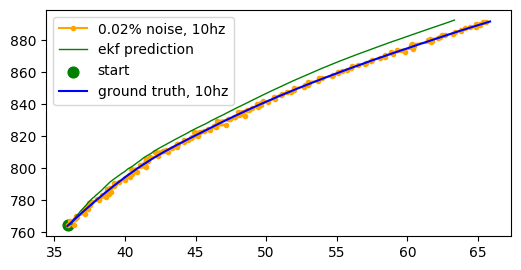

In [146]:
sample = 120
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_pred_ekf[sample]['y_noise'], rl_seg_pred_ekf[sample]['x_noise'], '-o', label='0.02% noise, 10hz', ms=3, c='orange')
plt.plot(rl_seg_pred_ekf[sample]['y_est'], rl_seg_pred_ekf[sample]['x_est'], '-', linewidth=1, label='ekf prediction', c='green')
plt.scatter(rl_seg_pred_ekf[sample]['y_est'][0], rl_seg_pred_ekf[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(rl_seg_pred_ekf[sample]['y'], rl_seg_pred_ekf[sample]['x'], label='ground truth, 10hz', c='blue')

plt.legend()

In [147]:
rl_seg_pred_ekf[sample]

,x_est,y_est,Vx_est,Vy_est,x_noise,y_noise,x,y
0,764.218924,35.972217,4.500002,0.004266,764.218924,35.972217,763.800057,35.923704
1,765.011689,36.244533,4.479013,0.561050,764.661641,36.383737,764.915179,36.060330
2,766.071580,36.274355,4.456270,0.302097,765.953498,36.246294,766.024523,36.195845
3,767.123927,36.295277,4.429423,0.306288,766.945418,36.121461,767.127263,36.330249
4,768.219622,36.394105,4.408836,0.314149,768.185530,36.450704,768.224226,36.466875
...,...,...,...,...,...,...,...,...
148,889.673501,62.330807,3.100977,0.748380,888.486611,64.457874,888.843691,64.733985
149,890.435156,62.586037,3.119559,0.756605,889.529521,65.111675,889.594807,65.009458
150,891.206985,62.830063,3.148792,0.763354,890.522407,64.879202,890.350874,65.288264
151,891.983406,63.085274,3.168319,0.767703,891.280189,65.550110,891.111894,65.569291


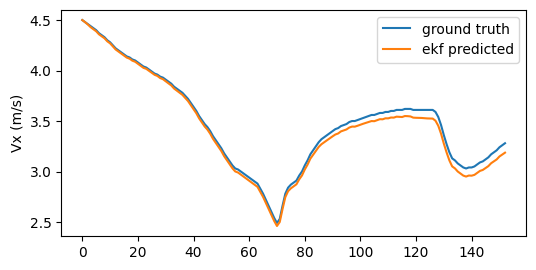

In [148]:
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_noise[sample]['Vx'].values, label='ground truth')
plt.plot(abs(rl_seg_pred_ekf[sample].reset_index()['Vx_est']), label='ekf predicted')
plt.ylabel('Vx (m/s)')
plt.legend()

In [149]:
# calculate prediction error in meters

x_max = -83.55144472
y_max = 42.24829894
x_min = -83.56611364
y_min = 42.23836889

y_pred_ekf_scale = []
rl_seg_pred_ekf_scaled = rl_seg_pred_ekf
# rl_seg_pred_ekf_scaled = inv_normalize_df(rl_seg_pred_ekf)

# estimation
for df in rl_seg_pred_ekf_scaled:

    y_pred_ekf_scale.append(
        np.append(df['y_est'].values.reshape(153, 1), df['x_est'].values.reshape(153, 1), axis=1
    ))

y_pred_ekf_scale = np.asarray(y_pred_ekf_scale)
great_circie_ekf_err = []

for i in np.arange(len(y_pred_ekf_scale)):
    for traj_i in np.arange(153):
        pred_coord = (y_pred_ekf_scale[i][traj_i][0], y_pred_ekf_scale[i][traj_i][1])
        actual_coord = (y_gt_scale[i][traj_i][0], y_gt_scale[i][traj_i][1])

        great_circie_ekf_err.append(math.dist(pred_coord, actual_coord)) # meter
        # great_circie_ekf_err.append(great_circle(pred_coord, actual_coord).miles * 1609.34) # meter

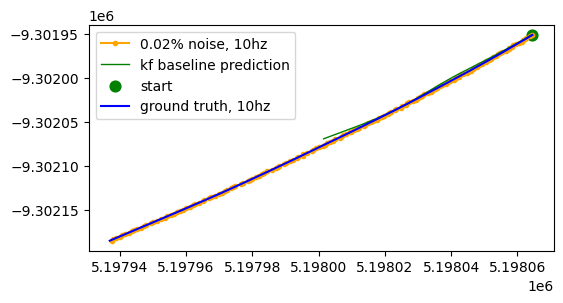

In [208]:
sample = 7
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_pred_ekf[sample]['y_noise'], rl_seg_pred_ekf[sample]['x_noise'], '-o', label='0.02% noise, 10hz', ms=3, c='orange')
plt.plot(rl_seg_pred_ekf[sample]['y_est'], rl_seg_pred_ekf[sample]['x_est'], '-', linewidth=1, label='kf baseline prediction', c='green')
plt.scatter(rl_seg_pred_ekf[sample]['y_est'][0], rl_seg_pred_ekf[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(rl_seg_pred_ekf[sample]['y'], rl_seg_pred_ekf[sample]['x'], label='ground truth, 10hz', c='blue')

plt.legend()

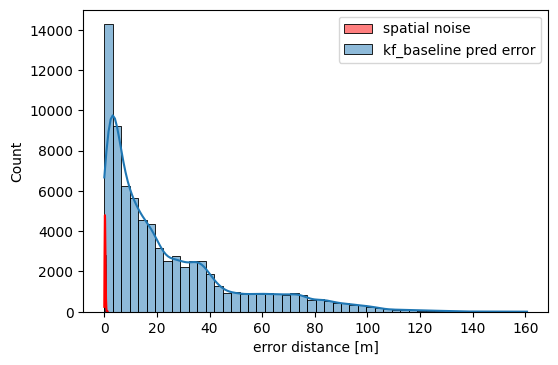

In [150]:
plt.figure(dpi=100)
ax = sns.histplot(
    great_circie_noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    great_circie_ekf_err, 
    bins=50, label='kf_baseline pred error', kde=True)

plt.xlabel('error distance [m]')
plt.legend()
plt.show()